In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
from scipy.stats import gaussian_kde

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure 5: US-Mexico border closure was uneffective in preventing importations
Calculating the difference in importation risk into San Diego from Mexico that we observed vs. using a counterfactual of 2019 mobility reveals that the US-Mexico border closure had a very limited effect.

We first load in the inferred infections for each location being analyses. `back-calculated-infections.csv` is generated with the `calculate-infections.R` script.

In [2]:
infections = pd.read_csv( "estimated-importation-risk/back-calculated-infections.csv", parse_dates=["date"] )
infections = infections.loc[infections["population"]!=0]
infections = infections.drop( columns=["Unnamed: 0"])
infections.head()

,date,location,presymptomatic_cases,asymptomatic_cases,estimated_infections,deaths,cases,population,naive_infections
23,2020-02-12,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
24,2020-02-13,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
25,2020-02-14,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
26,2020-02-15,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0
27,2020-02-16,Afghanistan,0.0,0.0,0.0,0,0,38928341,0.0


We next load mobility data from SafeGraph that has been prepared as in Zeller et al. 2020. As described in figureX_mobility-into-san-diego.ipynb we corrected an artifact we observed in the international mobility data. We also interpolate daily traveler counts from the weekly counts provided by SafeGraph.

Finally, we also add a counterfactual were the number of travelers from 2020 onwards is held at 2019 levels.

In [3]:
def fill_visitors( entry, smooth=True ):
    first = entry.iloc[0]
    entry = entry.set_index( "date_range_start" )
    entry = entry.reindex( pd.date_range( entry.index.min(), entry.index.max() ) )
    entry["week"] = entry.index.map( lambda x: Week.fromdate(x).startdate() )
    entry["true_visitor_count"] = entry.groupby( "week")["true_visitor_count"].transform( lambda x: x.sum() / 7 )
    entry["corrected_visitor_count"]  = entry.groupby( "week" )["corrected_visitor_count"].transform( lambda x: x.sum() / 7 )
    if smooth:
        entry["true_visitor_count"] = entry["true_visitor_count"].rolling( 7, min_periods=1 ).mean()
        entry["corrected_visitor_count"] = entry["corrected_visitor_count"].rolling( 7, min_periods=1 ).mean()
    entry["location"] = first["location"]
    return entry.reset_index()

def correct_mobility( entry ):
    start = "2019-03-01"
    end = "2019-12-29"

    return_df = entry.copy()
    mean2019 = entry.loc[entry["date_range_start"] < start,"true_visitor_count"].mean()
    mean2020 = entry.loc[entry["date_range_start"].between( end, "2020-03-01"),"true_visitor_count"].mean()
    ratio = mean2019 / mean2020

    return_df["corrected_visitor_count"] = return_df["true_visitor_count"]
    if (mean2019 == 0) or (mean2020 == 0):
        return return_df

    return_df.loc[entry["date_range_start"] > end, "corrected_visitor_count"] = return_df["true_visitor_count"] * ratio
    return return_df

def add_counter_travelers( entry ):
    entry["counter_travelers"] = entry["corrected_visitor_count"]
    entry.loc[entry["index"] > "2020-01-07","counter_travelers"] = entry["corrected_visitor_count"].shift( 365 )
    entry.loc[entry["index"] > "2021-01-07","counter_travelers"] = entry["corrected_visitor_count"].shift( 730 )
    return entry

st = pd.read_csv( "../data/mobility_states.csv", parse_dates=["date_range_start"] )
st = st.drop( columns=["California"] )
st = st.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

cr = pd.read_csv("../data/mobility_countries.csv", parse_dates=["date_range_start"] )
cr = cr.drop( columns=["Georgia", "United States"] )
cr = cr.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

ca = pd.read_csv( "../data/mobility_ca-counties.csv", parse_dates=["date_range_start"] )
ca = ca.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

mob = pd.concat( [st, cr, ca] )
mob = mob.groupby( "location" ).apply( correct_mobility ).reset_index( drop=True )
mob = mob.groupby( "location" ).apply( fill_visitors ).reset_index( drop=True )
mob = mob.groupby( "location" ).apply( add_counter_travelers ).reset_index( drop=True )

/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_13401/1926383318.py:21: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_13401/1926383318.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_13401/1926383318.py:21: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_13401/1926383318.py:21: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_13401/1926383318.py:21: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_13401/1926383318.py:21: RuntimeWarning: invalid value encountered in double

Merge mobility and infections dataset. Removing locations without either travelers or infections.

In [4]:
mob = mob.merge( infections, left_on=["location", "index"], right_on=["location", "date"], how="left" )
mob.loc[mob["index"].isna(),"index"] = mob["date"]
mob = mob.drop( columns=["date"] )
mob = mob.rename( columns={"index" : "date"} )
mob["population"] = mob.groupby( "location" )["population"].transform( "max" )

empty_locations = np.setdiff1d( mob.location.unique(), infections["location"].unique() )
mob = mob.loc[~mob["location"].isin(empty_locations)]

mob.head()

,date,location,true_visitor_count,corrected_visitor_count,week,counter_travelers,presymptomatic_cases,asymptomatic_cases,estimated_infections,deaths,cases,population,naive_infections
0,2019-01-07,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
1,2019-01-08,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
2,2019-01-09,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
3,2019-01-10,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN
4,2019-01-11,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,NaN,NaN,NaN,NaN,NaN,38928341.0,NaN


We calculate estimated infection rate as the sum of travellers that arrived from each location and the infection rate at that location.

In [5]:
mob = mob.fillna( 0.0 )
mob["estimated_infections"] = mob["estimated_infections"] / mob["population"]
mob["cases"] = mob["cases"] / mob["population"]
mob["eii_mean"] = mob["estimated_infections"] * mob["corrected_visitor_count"]
mob["eii_counter"] = mob["estimated_infections"] * mob["counter_travelers"]
mob.head()

,date,location,true_visitor_count,corrected_visitor_count,week,counter_travelers,presymptomatic_cases,asymptomatic_cases,estimated_infections,deaths,cases,population,naive_infections,eii_mean,eii_counter
0,2019-01-07,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0
1,2019-01-08,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0
2,2019-01-09,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0
3,2019-01-10,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0
4,2019-01-11,Afghanistan,4.366642,4.366642,2019-01-06,4.366642,0.0,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0


We calculate the percent change in travel from Mexico if there was no reduction in travel relative to 2019 levels.

In [6]:
test = mob.loc[(mob["location"]=="Mexico")&(mob["date"]>"2020-01-01"),["corrected_visitor_count","counter_travelers"]].sum()
print(f'Total increase in travel from Mexico: {(test["counter_travelers"] - test["corrected_visitor_count"]) / test["counter_travelers"]:.1%}' )

Total increase in travel from Mexico: 23.1%


In [7]:
frac = mob.groupby( "location" )["eii_mean"].sum()
frac = (frac / frac.sum())
print( f"Proportion of importation risk into San Diego originating from Mexico: {frac.loc['Mexico']:.1%}")

Proportion of importation risk into San Diego originating from Mexico: 10.4%


We next calculate the percent change in absolute importation risk from Mexico using the counterfactual, calculate the change in relative import risk from Mexico, and the percent change in absolute importation risk into San Diego.

In [8]:
eii_difference = mob.groupby( "location" )[["eii_mean", "eii_counter"]].sum()
eii_difference["diff"] = (eii_difference["eii_counter"] - eii_difference["eii_mean"]) / eii_difference["eii_counter"]
eii_difference["eii_mean_relative"] = eii_difference["eii_mean"] / eii_difference["eii_mean"].sum()

eii_obs_sum = eii_difference["eii_mean"].sum()
eii_difference.loc["Mexico","eii_mean"] = eii_difference.loc["Mexico","eii_counter"]
eii_cnt_sum = eii_difference["eii_mean"].sum()
eii_difference["eii_mean_relative_mx"] = eii_difference["eii_mean"] / eii_difference["eii_mean"].sum()

#eii_difference["eii_counter_relative"] = eii_difference["eii_counter"] / eii_difference["eii_counter"].sum()
#eii_difference["diff_relative"] =  eii_difference["eii_counter_relative"] - eii_difference["eii_mean_relative"]
#eii_difference.sort_values( "diff_relative" )

print( f"Total absolute increase in importation risk from Mexico: {eii_difference.loc['Mexico','diff']:.1%}" )
print( f"Change in relative importation risk from Mexico: {eii_difference.loc['Mexico','eii_mean_relative_mx']-eii_difference.loc['Mexico','eii_mean_relative']:.1%}" )
print( f"Change in absolute importation risk total: {(eii_cnt_sum/eii_obs_sum)-1:.1%}" )

Total absolute increase in importation risk from Mexico: 22.8%
Change in relative importation risk from Mexico: 2.7%
Change in absolute importation risk total: 3.1%


As a supplemental figure (12), we plot the observed and counterfactual estimated importation risk from Mexico over time.

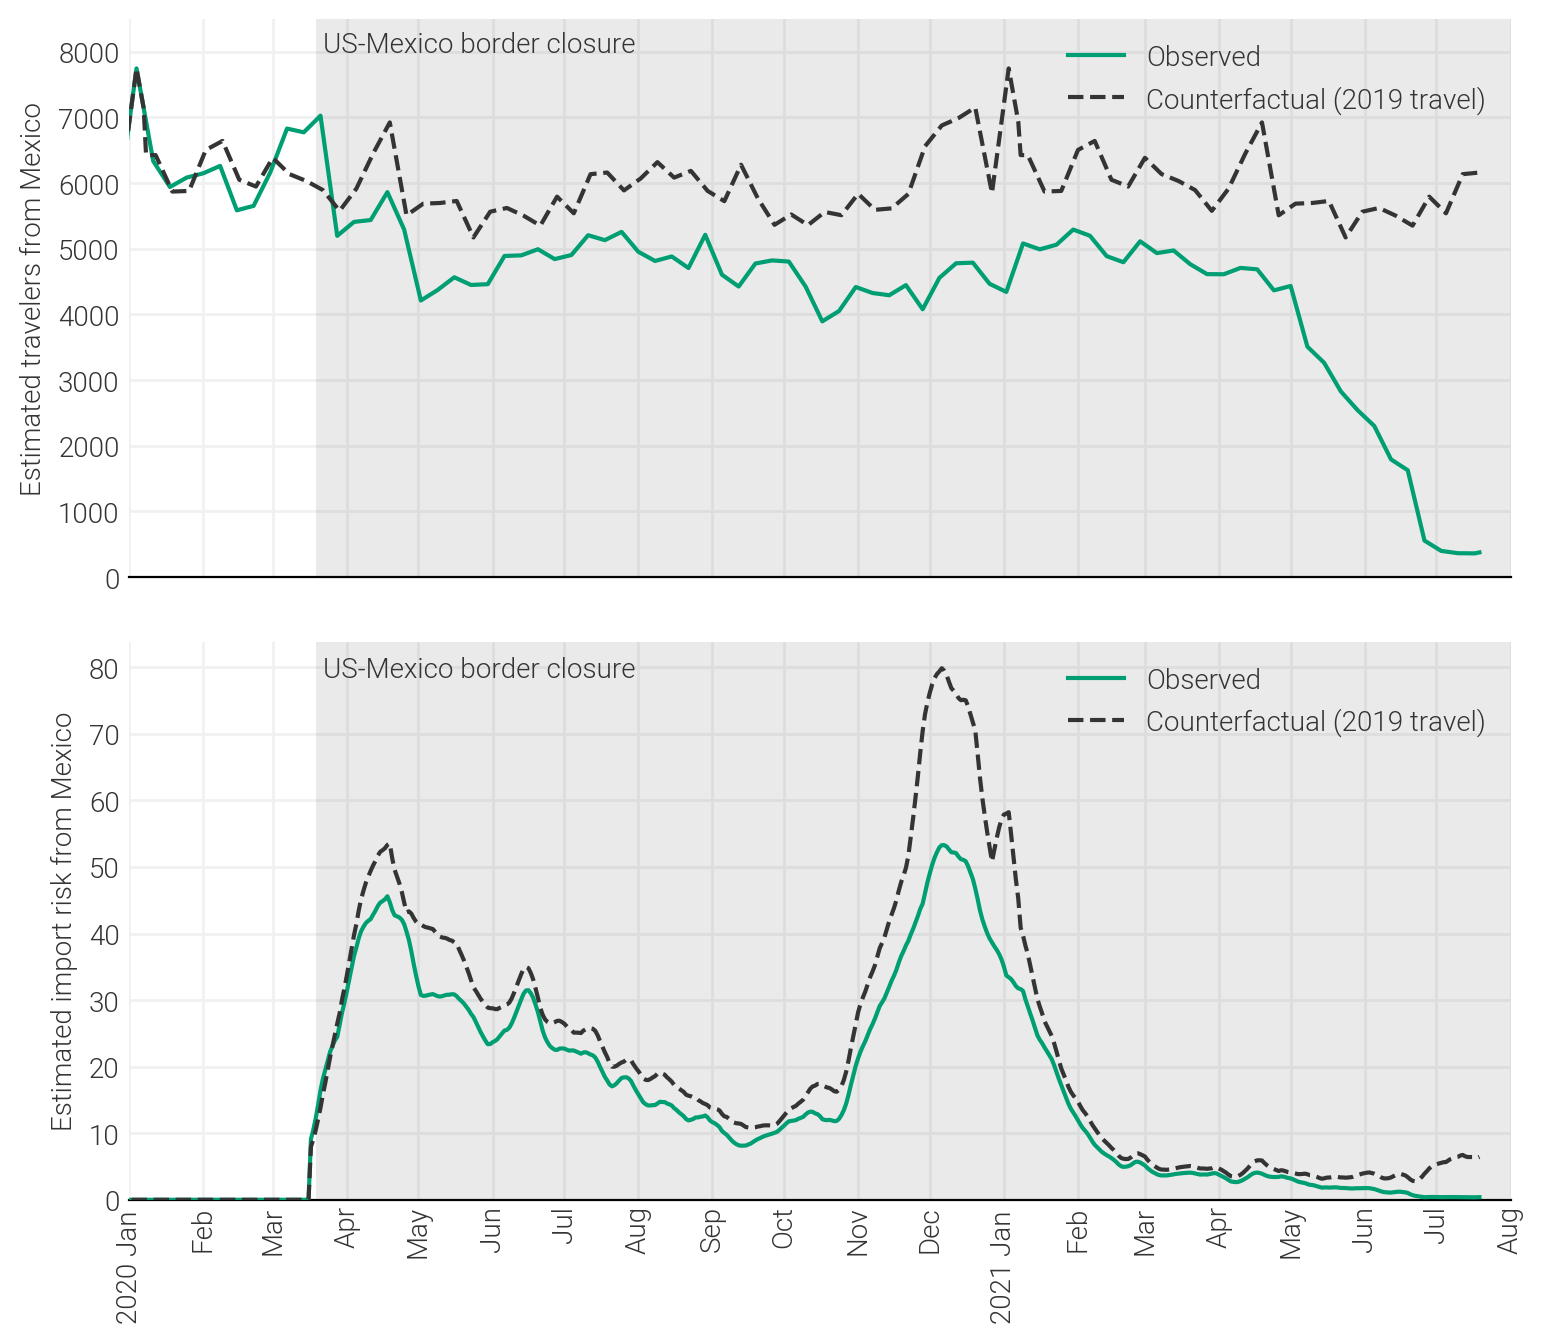

In [31]:
fig, ax = plt.subplots( dpi=200, figsize=(8,7), nrows=2, sharex=True )

ax[0].plot( mob.loc[mob["location"]=="Mexico","date"], mob.loc[mob["location"]=="Mexico","corrected_visitor_count"], color="#009E73", zorder=10, label="Observed" )
ax[0].plot( mob.loc[mob["location"]=="Mexico","date"], mob.loc[mob["location"]=="Mexico","counter_travelers"], color=COLOR, linestyle="--", zorder=10, label="Counterfactual (2019 travel)" )
ax[0].axvspan( pd.to_datetime( "2020-03-19" ), pd.to_datetime( "2021-11-08" ), color=COLOR, alpha=0.1, edgecolor=None, linewidth=0, zorder=5 )
ax[0].text( pd.to_datetime( "2020-03-22" ), 8000, "US-Mexico border closure", fontsize=10, zorder=6 )
basic_formatting( ax[0], which="both", ylabel="Estimated travelers from Mexico", ylims=(0,8500), xlims=(pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-08-01" )), ysize=10, xsize=10 )
#[ax[1].spines[j].set_visible( False ) for j in ax[1].spines if j not in spines]
ax[0].spines["bottom"].set_visible( True )
ax[0].set_ylim( 0 )
ax[0].legend( loc="upper right", frameon=False, fontsize=10 )
timeseries_formatting( ax[1] )
ax[0].set_facecolor( "w" )
ax[0].label_outer()


ax[1].plot( mob.loc[mob["location"]=="Mexico","date"], mob.loc[mob["location"]=="Mexico","eii_mean"], color="#009E73", zorder=10, label="Observed" )
ax[1].plot( mob.loc[mob["location"]=="Mexico","date"], mob.loc[mob["location"]=="Mexico","eii_counter"], color=COLOR, linestyle="--", zorder=10, label="Counterfactual (2019 travel)" )
ax[1].axvspan( pd.to_datetime( "2020-03-19" ), pd.to_datetime( "2021-11-08" ), color=COLOR, alpha=0.1, edgecolor=None, linewidth=0, zorder=5 )
ax[1].text( pd.to_datetime( "2020-03-22" ), 78.5, "US-Mexico border closure", fontsize=10, zorder=6 )
basic_formatting( ax[1], which="both", ylabel="Estimated import risk from Mexico", xlims=(pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-08-01" )), ysize=10, xsize=10 )
#[ax[1].spines[j].set_visible( False ) for j in ax[1].spines if j not in spines]
ax[1].spines["bottom"].set_visible( True )
ax[1].set_ylim( 0 )
ax[1].legend( loc="upper right", frameon=False, fontsize=10 )
timeseries_formatting( ax[1] )
ax[1].set_facecolor( "w" )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureS12_travel-import-risk-counterfactual-mexico.pdf", pad_inches=0, transparent=True )
plt.show()

To contextualize how big of an effect this increase would have, we calculate the change in importation risk from all locations using a counterfactual and compare to Mexico

In [10]:
mob["month"] = pd.to_datetime( mob["date"].dt.strftime('%Y-%m-01' ) )
counter_mx = mob.copy()

counter_mx.loc[counter_mx["location"]=="Mexico","eii_mean"] = counter_mx.loc[counter_mx["location"]=="Mexico","eii_counter"]
counter_mx = counter_mx.groupby( "month" )["eii_mean"].sum()
observed = mob.groupby( "month" )["eii_mean"].sum()

counter_mx = pd.concat( [observed, counter_mx], axis=1 )
counter_mx.columns = ["observed", "counter_mx"]
counter_mx["increase"] = (counter_mx["counter_mx"] / counter_mx["observed"]) - 1

print( counter_mx["increase"].mean() )

0.03029875095283123


Here we plot Figure 5A, the percent increase in total importation risk into San Diego in the counterfactual situation were mobility from Mexico is held constant at 2019 levels, relative to observed travel.

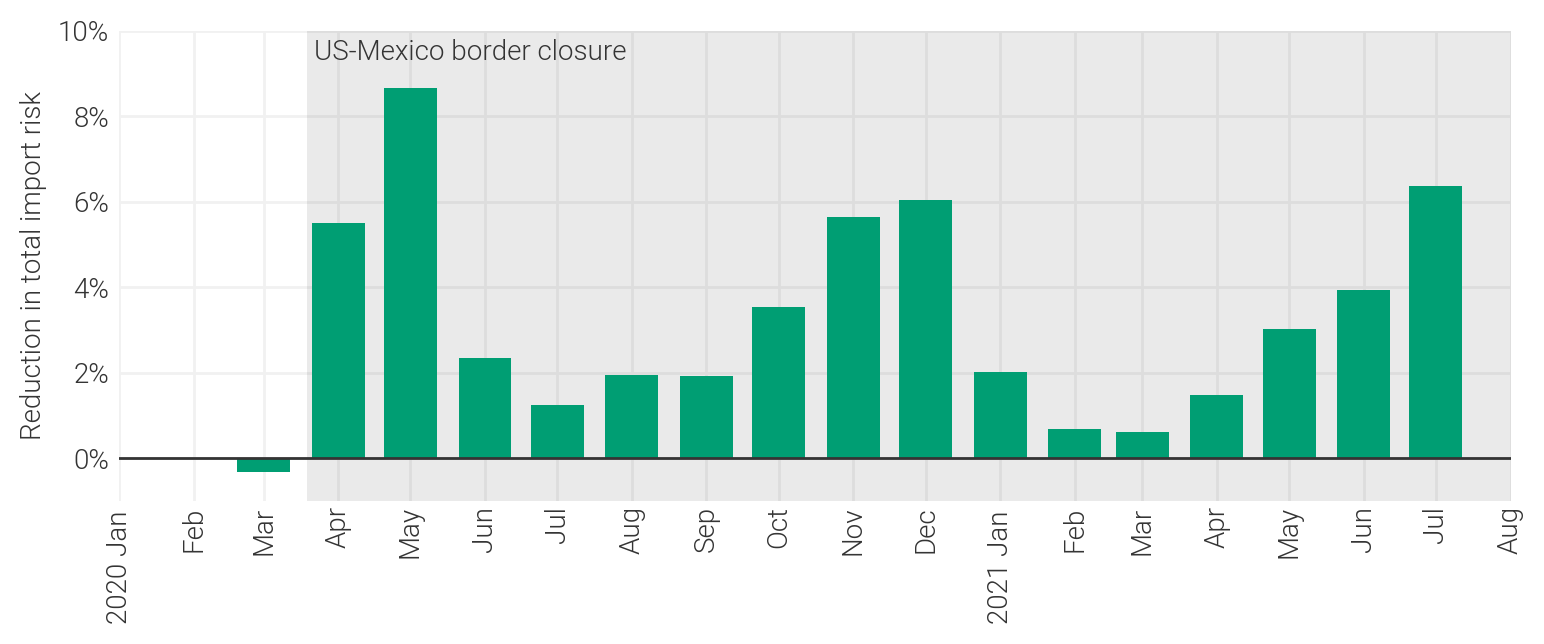

In [27]:
fig, ax = plt.subplots( dpi=200, figsize=(8,3.5) )
ax.bar( x=counter_mx.index, height=counter_mx["increase"], color="#009E73", width=22, zorder=10, align="center" )
ax.axvspan( pd.to_datetime( "2020-03-19" ), pd.to_datetime( "2021-11-08" ), color=COLOR, alpha=0.1, edgecolor=None, linewidth=0, zorder=5 )
ax.text( pd.to_datetime( "2020-03-22" ), 0.093, "US-Mexico border closure", fontsize=10, zorder=6 )
basic_formatting( ax, which="both", spines=[], ylabel="Reduction in total import risk", xlims=(pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2021-08-01" )), ylims=(-0.01, 0.1), ysize=10, xsize=10 )
timeseries_formatting( ax )

ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0 ) )
ax.axhline( 0, color=COLOR, linewidth=1, zorder=11 )
ax.set_facecolor( "w" )

plt.tight_layout()
plt.savefig( "../analyses/plots/figure5_import-risk-counterfactual-mexico.pdf", pad_inches=0, transparent=True )
plt.show()

Next we plot Figure 5B, counterfactual importation risk for all locations relative to their observed importation risk. We label the 5 locations with the greatest absolute difference between their counterfactual and observed importation risk.

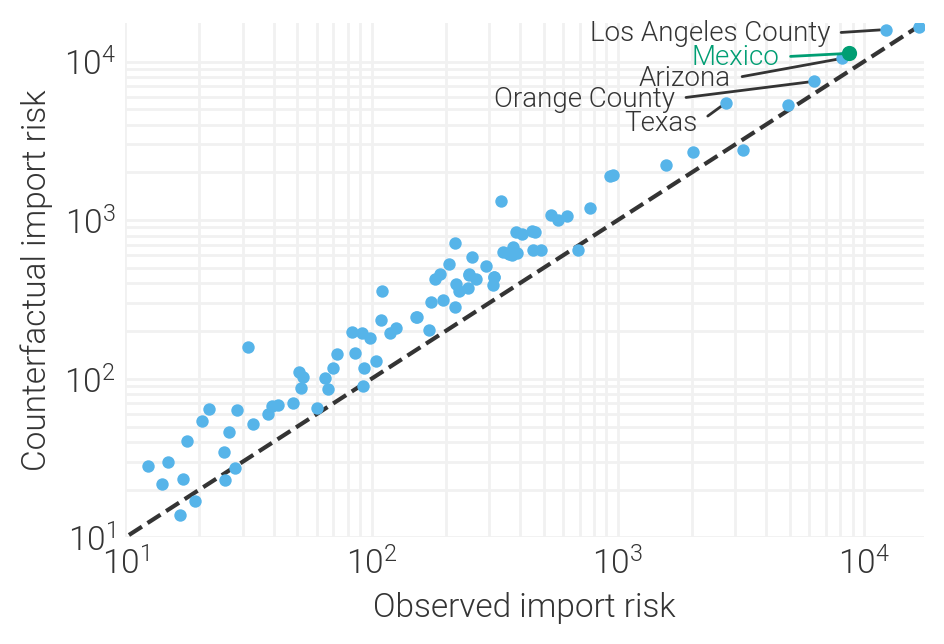

In [28]:
eii_difference = mob.groupby( "location" )[["eii_mean", "eii_counter"]].sum()
eii_difference["diff"] = eii_difference["eii_counter"] - eii_difference["eii_mean"]
eii_difference = eii_difference.loc[eii_difference["eii_mean"] > 10]

fig, ax = plt.subplots( dpi=200, figsize=(5,3.5) )
ax.scatter( "eii_mean", "eii_counter", data=eii_difference, zorder=10, s=20, color="#56B4E9", linewidth=0 ) #

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, '--', color=COLOR, zorder=5)

loc_pos = {
    "Los Angeles County" : [-20,-4],
    "Texas" : [-10,-10],
    "Mexico" : [-25,-4],
    "Arizona" : [-40,-10],
    "Orange County" : [-50,-9]
}
arrowprops = dict(arrowstyle="-", relpos=(1,0.5), color=COLOR )
for loc, sr in eii_difference.sort_values( "diff", ascending=False ).head(5).iterrows():
    if loc == "Mexico":
        ax.annotate( loc, (sr["eii_mean"], sr["eii_counter"]), loc_pos[loc], textcoords="offset points", fontsize=10, ha="right", color="#009E73", arrowprops=dict(arrowstyle="-", relpos=(1,0.5), color="#009E73" ), zorder=20 )
        ax.scatter( sr["eii_mean"], sr["eii_counter"], zorder=11, s=20, color="#009E73" )
    else:
        ax.annotate( loc, (sr["eii_mean"], sr["eii_counter"]), loc_pos[loc], textcoords="offset points", fontsize=10, ha="right", color=COLOR, arrowprops=arrowprops )

ax.set_xscale( "log" )
ax.set_yscale( "log" )

basic_formatting( ax, spines=[], which="both", xlabel="Observed import risk", ylabel="Counterfactual import risk", xsize=12, ysize=12, xlims=(10, lims[1]), ylims=(10, lims[1]) )
ax.tick_params( axis="x", rotation=0 )
ax.set_facecolor( "w" )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure5_import-risk-counter.pdf" )
plt.show()

Here we show the locations with the largest difference between observed and counterfactual importation risk. 

In [13]:
eii_difference.sort_values( "diff", ascending=False ).head(10)

,eii_mean,eii_counter,diff
location,,,
Los Angeles County,12239.650938,15903.905515,3664.254577
Texas,2739.567148,5467.666401,2728.099253
Mexico,8686.975015,11259.277204,2572.302189
Arizona,8158.942309,10473.963191,2315.020883
Orange County,6258.565549,7499.938822,1241.373273
New Jersey,334.109203,1327.477849,993.368646
New York,954.147698,1915.030094,960.882397
Illinois,928.239806,1888.157689,959.917884
Nevada,2013.768270,2683.395229,669.626959


We plot Figure 5C, the distribution of the relative difference between each locations counterfactual and observed imporation risk. Difference for Mexico is indicated by a dashed vertical line.

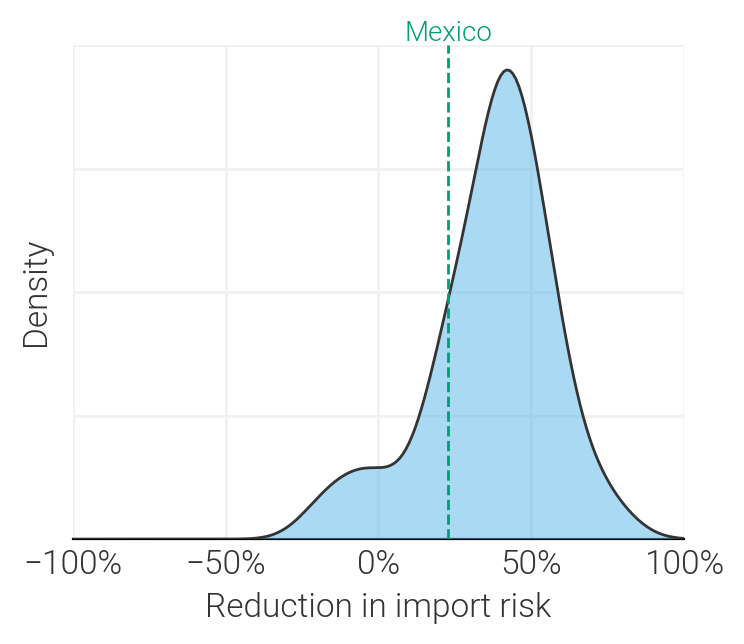

In [29]:
#eii_difference["log_diff"] = np.log( eii_difference["eii_counter"] ) - np.log( eii_difference["eii_mean"] )
eii_difference["percent_diff"] = (eii_difference["eii_counter"] - eii_difference["eii_mean"]) / eii_difference["eii_counter"]
mex_log_diff = eii_difference.loc["Mexico","percent_diff"]

fig, ax = plt.subplots( dpi=200, figsize=(4,3.5) )

data = eii_difference["percent_diff"]
x_grid = np.linspace( -1, 1, 201 )
kde = gaussian_kde( data )
y_grid = kde.evaluate( x_grid )
y_grid = y_grid / y_grid.max() * 0.95
ax.plot([x for x in x_grid],y_grid,color=COLOR,lw=1,zorder=101)
ax.fill_between(x_grid,[y for y in y_grid], facecolor="#56B4E9", edgecolor='none', alpha=0.5, zorder=100)

#eii_difference["log_diff"].plot( kind="kde", ax=ax )
ax.axvline( eii_difference.loc["Mexico","percent_diff"], color="#009E73", linestyle="dashed", linewidth=1, zorder=102 )
ax.annotate( "Mexico", (mex_log_diff, ax.get_ylim()[1]), (0,2), textcoords="offset points", ha="center", size=10, color="#009E73" )
ax.set_ylim( 0 )
basic_formatting( ax, which="both", ylabel="Density", xlabel="Reduction in import risk", xlims=(-1, 1), ylims=(0,1), xsize=12, ysize=12 )
ax.xaxis.set_major_formatter( PercentFormatter(1) )
ax.tick_params( axis="x", rotation=0 )
ax.set_yticks( [0,0.25,0.5,0.75,1])
ax.set_yticklabels( [] )
ax.set_facecolor( "w" )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure5_import-risk-counter-magnitude.pdf" )
plt.show()

Here we calculate what percent of locations experienced a greater reduction in import risk than Mexico. As well, we c

In [43]:
(eii_difference["percent_diff"]>mex_log_diff).sum() / eii_difference.shape[0]

0.8

In [44]:
eii_difference.median()

eii_mean        193.080753
eii_counter     357.523942
diff            122.780562
percent_diff      0.400660
dtype: float64

Plot the two previous panels together so that fonts match, etc.

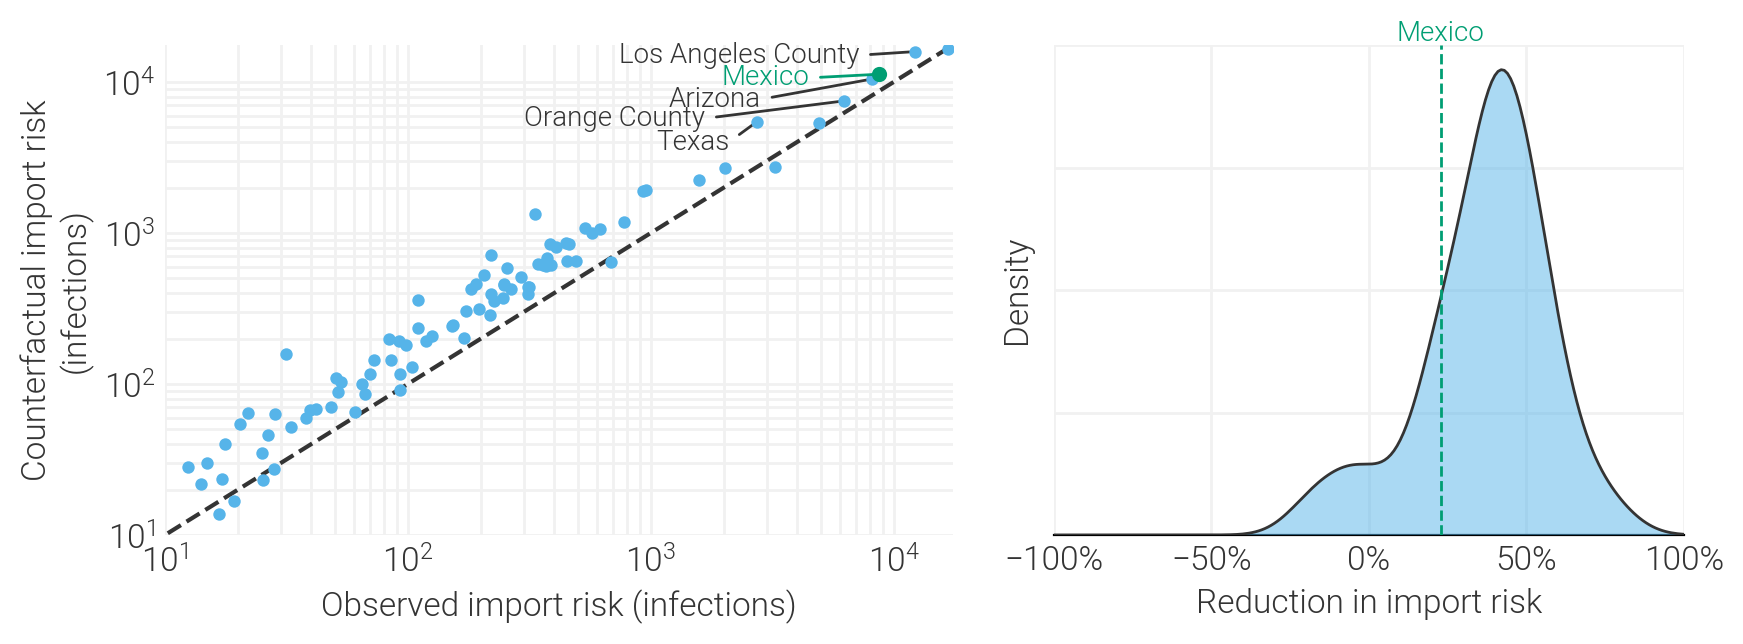

In [30]:
eii_difference = mob.groupby( "location" )[["eii_mean", "eii_counter"]].sum()
eii_difference["diff"] = eii_difference["eii_counter"] - eii_difference["eii_mean"]
eii_difference = eii_difference.loc[eii_difference["eii_mean"] > 10]

fig, ax = plt.subplots( dpi=200, figsize=(9,3.5), ncols=2, gridspec_kw={"width_ratios" : (5,4)} )
ax[0].scatter( "eii_mean", "eii_counter", data=eii_difference, zorder=10, s=20, color="#56B4E9", linewidth=0 ) #

lims = [
    np.min([ax[0].get_xlim(), ax[0].get_ylim()]),  # min of both axes
    np.max([ax[0].get_xlim(), ax[0].get_ylim()]),  # max of both axes
]
ax[0].plot(lims, lims, '--', color=COLOR, zorder=5)

loc_pos = {
    "Los Angeles County" : [-20,-4],
    "Texas" : [-10,-10],
    "Mexico" : [-25,-4],
    "Arizona" : [-40,-10],
    "Orange County" : [-50,-9]
}
arrowprops = dict(arrowstyle="-", relpos=(1,0.5), color=COLOR )
for loc, sr in eii_difference.sort_values( "diff", ascending=False ).head(5).iterrows():
    if loc == "Mexico":
        ax[0].annotate( loc, (sr["eii_mean"], sr["eii_counter"]), loc_pos[loc], textcoords="offset points", fontsize=10, ha="right", color="#009E73", arrowprops=dict(arrowstyle="-", relpos=(1,0.5), color="#009E73" ), zorder=20 )
        ax[0].scatter( sr["eii_mean"], sr["eii_counter"], zorder=11, s=20, color="#009E73" )
    else:
        ax[0].annotate( loc, (sr["eii_mean"], sr["eii_counter"]), loc_pos[loc], textcoords="offset points", fontsize=10, ha="right", color=COLOR, arrowprops=arrowprops )

ax[0].set_xscale( "log" )
ax[0].set_yscale( "log" )

basic_formatting( ax[0], spines=[], which="both", xlabel="Observed import risk (infections)", ylabel="Counterfactual import risk\n(infections)", xsize=12, ysize=12, xlims=(10, lims[1]), ylims=(10, lims[1]) )
ax[0].tick_params( axis="x", rotation=0 )
ax[0].set_facecolor( "w" )

eii_difference["percent_diff"] = (eii_difference["eii_counter"] - eii_difference["eii_mean"]) / eii_difference["eii_counter"]
mex_log_diff = eii_difference.loc["Mexico","percent_diff"]

data = eii_difference["percent_diff"]
x_grid = np.linspace( -1, 1, 201 )
kde = gaussian_kde( data )
y_grid = kde.evaluate( x_grid )
y_grid = y_grid / y_grid.max() * 0.95
ax[1].plot([x for x in x_grid],y_grid,color=COLOR,lw=1,zorder=101)
ax[1].fill_between(x_grid,[y for y in y_grid], facecolor="#56B4E9", edgecolor='none', alpha=0.5, zorder=100)

#eii_difference["log_diff"].plot( kind="kde", ax=ax )
ax[1].axvline( eii_difference.loc["Mexico","percent_diff"], color="#009E73", linestyle="dashed", linewidth=1, zorder=102 )
ax[1].annotate( "Mexico", (mex_log_diff, ax[1].get_ylim()[1]), (0,2), textcoords="offset points", ha="center", size=10, color="#009E73" )
ax[1].set_ylim( 0 )
basic_formatting( ax[1], which="both", ylabel="Density", xlabel="Reduction in import risk", xlims=(-1, 1), ylims=(0,1), xsize=12, ysize=12 )
ax[1].xaxis.set_major_formatter( PercentFormatter(1) )
ax[1].tick_params( axis="x", rotation=0 )
ax[1].set_yticks( [0,0.25,0.5,0.75,1])
ax[1].set_yticklabels( [] )
ax[1].set_facecolor( "w" )

plt.tight_layout()
plt.savefig( "../analyses/plots/figure5_import-risk-counter-vs-observed.pdf" )
plt.show()